In [1]:
#imports
import numpy as np
import torch
import seaborn as sns # comment this out if seaborn is not available
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm
from torch.utils.data import Dataset, DataLoader
from time import time
from scipy import stats as st
from mode_torch import MoDeLoss
plt.style.use("paper")
np.random.seed(42)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
def make_plot(model_legendre,Y,bins=50,title="DNN"):  
        validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
        cuts = []
        efficiencies = np.linspace(0.1,0.9,9)[::-1]
        for eff in efficiencies:
            cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
        scores = np.array(model_legendre(Y).tolist())
    
        R50 = 1/((scores[y_test==1]<cuts[4]).sum()/(y_test==1).sum())
        
        sorted_m = np.argsort(m_t)
        m = m_t[sorted_m].reshape(bins,-1).mean(axis=1)
        scores = scores[sorted_m].reshape(bins,-1)

        fig, ax  = plt.subplots(1,1,figsize=[8,5],dpi=120,sharex=True)
        for j,cut in enumerate(cuts):
            c = f"C{j}" if j!= 6 else f"C11"
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
            ax.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

        ax.set_ylabel(r"False Pos. Rate",fontsize=17)
        ax.text(-0.75,0.9,f"R50:{R50:.1f}",fontsize=17)
        ax.set_ylim([-0.02,1.02])
        ax.set_title(title, fontsize=17)
        ax.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)
        ax.set_xlabel(r"$m$",fontsize=19)

        fig.tight_layout(pad=0)
        plt.show()
        return
def swish(x):
    return x*torch.sigmoid(x)
class Model(torch.nn.Module):
    def __init__(self,input_size=10,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size,16)
        self.linear1 = torch.nn.Linear(16,32)
        self.linear2 = torch.nn.Linear(32,64)
        self.linear3 = torch.nn.Linear(64,64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64,1)
        # Defaults
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = swish(self.linear(x))
        x = swish(self.linear1(x))
        x = swish(self.linear2(x))
        x = swish(self.linear3(x))
        x = self.batchnorm(x)
        x = torch.sigmoid(self.out(x))
        return x
    def fit(self,traindataset,epochs=200,batch_size=None, shuffle=False, num_workers=None, optimizer=None,scheduler=None,loss=None,interval=100,valdataset=None,drop_last=False,metrics=None,delay_loss=False,pass_x_biased=False,device='cpu',verbose=True):
        """
        Fit model to traindataset.

        Parameters
        ----------
        traindataset : DataSet
            The DataSet [torch.utils.data.Dataset] instance containing the training data. Used to create a DataLoader. Must return x,y,m where x is the vector of features, y is the label and m is the biased feature.
        epochs : int
            Number of epochs to train.
        batch_size : int
            Size of the batch.
        shuffle : bool
            If True shuffles the training data.
        num_workers : int
            Passed to DataLoader.
        optimizer : torch.optim
            Optimizer to use in the training. Defaults to torch.optim.SGD(lr-1e-3).
        scheduler : torch.optim.lr_scheduler
            Scheduler used to change the learning rate.
        loss : Callable
            Criterion to minimize. Defaults to torch.nn.MSELoss
        interval : int
            Log and print progress every epochs mod interval == 0.
        valdataset : DataSet
            Same as traindataset but for the validation data.
        drop_last : bool
            If drop_last the DataLoader will only keep floor(len(traindataset)/batch_size). Used if the loss requires batches of the same size.
        metrics : [Metrics,Metrics]
            Metrics object where to store the training/validation metrics.
        delay_loss : int
            Delay using the provided loss for delay_loss epochs. Optmizer uses WeightedMSE before that.
        pass_x_biased : bool
            If true, passes the biased feature as a third argument to the loss function.
        device : str or torch.device
            Which device to use. Defaults to cpu.
        """
        self.optimizer = optimizer or torch.optim.Adam(self.parameters(),lr=1e-3)
        self.loss = loss if loss is not None else lambda x,y: torch.mean((x-y)**2)
        self.metrics = metrics or [Metrics(),Metrics(validation=True)]
        self.losses = []
        
        validation_generator = DataLoader(valdataset,batch_size=len(valdataset),shuffle=False)
        training_generator = DataLoader(traindataset, batch_size=batch_size, shuffle=shuffle,num_workers=num_workers,drop_last=drop_last)
        t0 = time()
        loss = 0
        acc = 0
        
        print("Entering Training...")
        for epoch in range(1,epochs+1):
            # feed forward
            for item in training_generator:
                x,y,m,weights = item
                if device!='cpu':
                    x,y,m,weights = x.to(device),y.to(device),m.to(device), weights.to(device)
                self.train()
                yhat = self(x).view(-1)
                if pass_x_biased:
                    l = self.loss(pred=yhat,target=y,x_biased=m,weights=weights)
                else:
                    l = self.loss(pred=yhat,target=y)
                    
                l.backward()
                self.metrics[0].losses.append(l.item())
                self.optimizer.step()
                self.optimizer.zero_grad()
            #Validation and Printing
            if epoch % interval ==0 or epoch == epochs or epoch==1:
                self.train(False)
                for x,yval,m_val,weights in  validation_generator:
                    break
                if device!='cpu':
                    x,yval,m_val = x.to(device),yval.to(device),m_val.to(device)
                yhat_val = self(x).view(-1)
                l_val = torch.mean((yhat_val-yval)**2)
                self.metrics[0].calculate(pred=yhat.data,target=y,m=m)
                self.metrics[1].calculate(pred=yhat_val.data,target=yval,m=m_val,l=l_val.item())
                if verbose:
                    acc = self.metrics[0].accs[-1]
                    R50 = self.metrics[1].R50[-1]
                    JSD = self.metrics[1].JSD[-1]
                    acc_val = self.metrics[1].accs[-1]
                    entry = 'Epoch:{:04d}/{:04d}  ({t:<5.1f}s)\n'.format(epoch,epochs,t=time()-t0) +\
                            ' Train: loss:{:.4f}, acc:{:.1f}%'.format(l.item(),100*acc) +\
                            ' || Val: loss: {:.4f}, acc:{:.1f}%, R50: {:.4f}, 1/JSD: {:.4f}'.format(
                            l_val.item(), 100.* acc_val,R50,1/JSD)
                    print(entry)
                if scheduler:
                    scheduler.step(l_val.item())
                del x, yval, m, l_val, m_val, weights
                self.yhat_val = yhat_val.data.cpu()
        del l,y,item, yhat, yhat_val
        torch.cuda.empty_cache()    
class DataSet(Dataset):
    def __init__(self, samples,labels,m=None,weights=None):
        'Initialization'
        self.labels = labels
        self.samples = samples
        self.m = m
        if len(samples)!=len(labels):
            raise ValueError(f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")
        if weights is None:
            self.weights = np.ones_like(labels)
        else:
            if len(weights)!=len(labels):
                raise ValueError(f"should have the same number of weights({len(weights)}) as there are samples({len(labels)})")
            self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Select sample
        X = self.samples[index]
        y = self.labels[index]
        m = self.m[index] if self.m is not None else self.m
        w = self.weights[index]
        return  X,y,m,w  
class Metrics():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==0).sum()
        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[(targets==1)&(preds>c)],bins=50,density=True)
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=bins,density=True)
                JSD = 0.5*(sum(hist1*np.log2(hist1/0.5*(hist1+hist2)))+sum(hist2*np.log2(hist2/0.5*(hist1+hist2))))
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)          
def find_threshold(L,mask,x_frac):
    """
    Calculate c such that x_frac of the array is less than c.

    Parameters
    ----------
    L : Array
        The array where the cutoff is to be found
    mask : Array,
        Mask that returns L[mask] the part of the original array over which it is desired to calculate the threshold.
    x_frac : float
        Of the area that is lass than or equal to c.

    returns c (type=L.dtype)
    """
    max_x = mask.sum()
    x = int(np.round(x_frac * max_x))
    L_sorted = np.sort(L[mask.astype(bool)])
    return L_sorted[x]

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but different for signal and background.

In [3]:
def get_quad_mass(a=-1,b=1,n=int(5e5/2),umin=0,umax=1):
    u = np.random.uniform(umin,umax,n)
    alpha = 12/(b-a)**3
    beta = (a+b)/2
    cube_root = lambda x: abs(x)**(1./3) * np.sign(x)
    F_inv_quad = lambda u: cube_root(3*u/alpha-(beta-a)**3)+ beta
    return F_inv_quad(u)
def get_lin_mass(a=.5,b=.5,n=int(5e5/2),umin=0,umax=1):
    u = np.random.uniform(umin,umax,n)
    return - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
class tri_lin(st.rv_continuous):
    def _pdf(self,x,a,b,c):
        y = 2/(b-a) * np.piecewise(x,[x<c,x==c,(c<x)&(x<=b)],[lambda x: (x-a)/(c-a),
                                                       lambda x: x,
                                                       lambda x: (b-x)/(b-c)])
        return y
    def _argcheck(self,a,b,c):
        return a<=b
    def _get_support(self,a,b,c):
        return a,b
    def _ppf(self,u,a,b,c):
        Fc = (c-a)/(b-a)
        return np.piecewise(u,[u<Fc,u>=Fc],[lambda u: a + np.sqrt(u*(b-a)*(c-a)),
                                                          lambda u: b - np.sqrt((1-u)*(b-a)*(b-c))])
    def trunc_rvs(self, *args, size=None,umax=0,umin=1):
        U = np.random.uniform(umin,umax,size=size)
        Y = self._ppf(U, *args)
        return Y

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


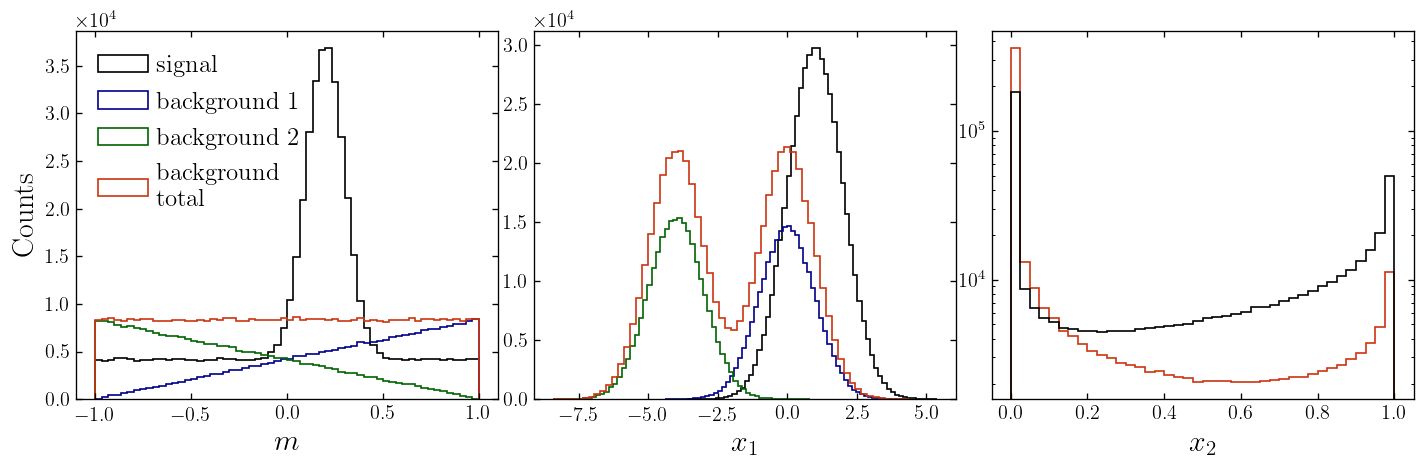

In [4]:
# data
np.random.seed(42)
n_s = int(5e5)
n_b = int(5e5/2)
n_s_gauss_frac = 0.5

m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.2,0.1,size=int(n_s_gauss_frac*n_s))])
m_b1 = get_lin_mass(.5,.5,n_b)
m_b2=  get_lin_mass(-.5,.5,n_b)
m_b = np.concatenate([m_b1,m_b2])
m_t1 = get_lin_mass(.5,.5,n_b)
m_t2=  get_lin_mass(-.5,.5,n_b)
m_t  = np.concatenate([m_t1,m_t2])

x1_b1 = np.random.normal(0,1,n_b)
x1_b2 = np.random.normal(-4,1,n_b)
x1_b  = np.concatenate([x1_b1,x1_b2])
x1_s  = np.random.normal(1,1,n_s)
x1_t  = np.concatenate([np.random.normal(0,1,n_b),np.random.normal(-4,1,n_b)])

x2_s = np.exp(-(m_s-0.2)**2/(2*(0.1)**2))
x2_b = np.exp(-(m_b-0.2)**2/(2*(0.1)**2))
x2_t = np.exp(-(m_t-0.2)**2/(2*(0.1)**2))



fig ,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12,4),dpi=120,sharey=False)

_,bins,_ = ax1.hist(m_s,bins=60,density=False,alpha=1,label='signal',histtype="step",color='black')
ax1.hist(m_b1,bins=bins,density=False,label='background 1',histtype="step",color='darkblue',alpha=1)
ax1.hist(m_b2,bins=bins,density=False,label='background 2',histtype="step",color='darkgreen',alpha=1)
ax1.hist(m_b,bins=bins,density=False,alpha=1,label='background\n total',histtype="step",color='C2')
ax1.legend(loc="upper left",fontsize=15,handletextpad=0.3)
ax1.set_xlabel(r"$m$",fontsize=18)
ax1.set_ylabel("Counts",fontsize=18)
#ax1.set_ylim([0,3.6e4])
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax2.hist(x1_s,bins=60,density=False,alpha=1,label='signal',color='black',histtype='step')
ax2.hist(x1_b1,bins=60,density=False,label='background 1',color='darkblue',histtype="step",alpha=1)
ax2.hist(x1_b2,bins=60,density=False,label='background 2',color='darkgreen',histtype="step",alpha=1)
ax2.hist(x1_b,bins=60,density=False,alpha=1, label='background total',histtype="step",color="C2")
ax2.set_xlabel(r"$x_1$",fontsize=18)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

_,bins,_ = ax3.hist(x2_b,bins=40,density=False,alpha=1, label='background',histtype="step",color="C2")
ax3.hist(x2_s,bins=bins,density=False,alpha=1,label='signal',histtype="step",color='black')
ax3.set_xlabel(r"$x_2$",fontsize=18)
ax3.set_yscale("log")
fig.tight_layout(w_pad=0.2)
fig.savefig("./plots/toy/data.pdf")
##############################################finalize 
x = np.concatenate([np.stack([m_s,x1_s,x2_s],axis=1),
                   np.stack([m_b,x1_b,x2_b],axis=1)])
y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,x1_t,x2_t],axis=1) 
y_test = np.ones(x_test.shape[0])
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train.astype('float32')[:,1:],y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val.astype('float32')[:,1:],y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test[:,1:]).float()
traindataset2 = DataSet(x_train.astype('float32')[:,1:-1],y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset2 = DataSet(x_val.astype('float32')[:,1:-1],y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor2= torch.from_numpy(x_test[:,1:-1]).float()

In [5]:
params = {'epochs'       : 10,
          'interval'     : 50,
          'batch_size'   : 2**16,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }
lr = 1e-2

Entering Training...
Epoch:0001/0010  (4.5  s)
 Train: loss:0.9557, acc:74.2% || Val: loss: 0.1677, acc:74.4%, R50: 14.9433, 1/JSD: 0.2004
Epoch:0010/0010  (30.3 s)
 Train: loss:0.2950, acc:68.8% || Val: loss: 0.2036, acc:69.8%, R50: 7.9482, 1/JSD: 11.5442


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


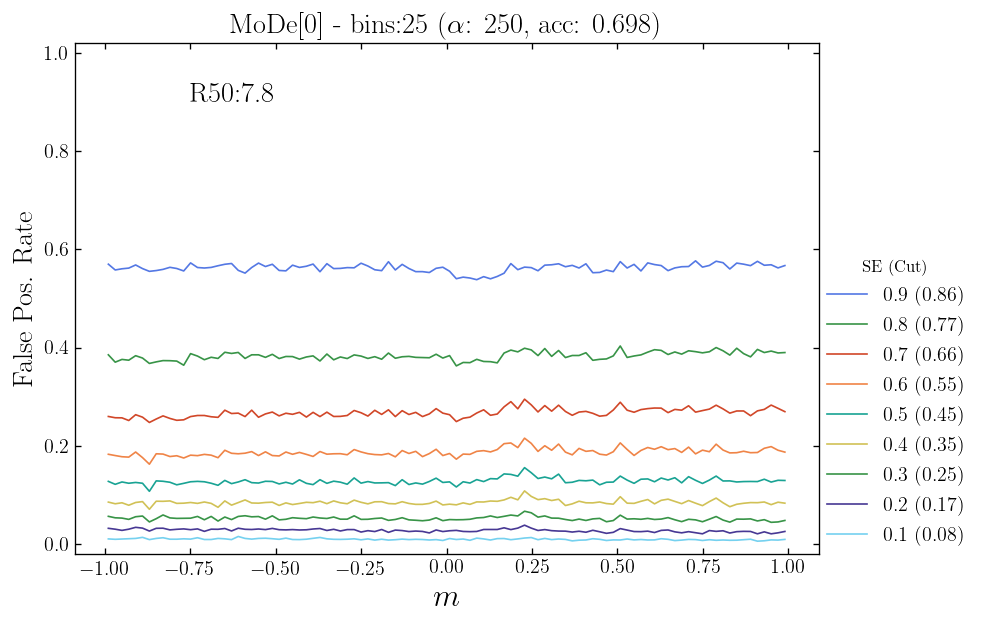

Entering Training...
Epoch:0001/0010  (4.6  s)
 Train: loss:0.2432, acc:80.3% || Val: loss: 0.1537, acc:77.9%, R50: 13.4496, 1/JSD: 0.2155
Epoch:0010/0010  (30.7 s)
 Train: loss:0.2241, acc:79.3% || Val: loss: 0.1353, acc:79.7%, R50: 13.1170, 1/JSD: 0.2167


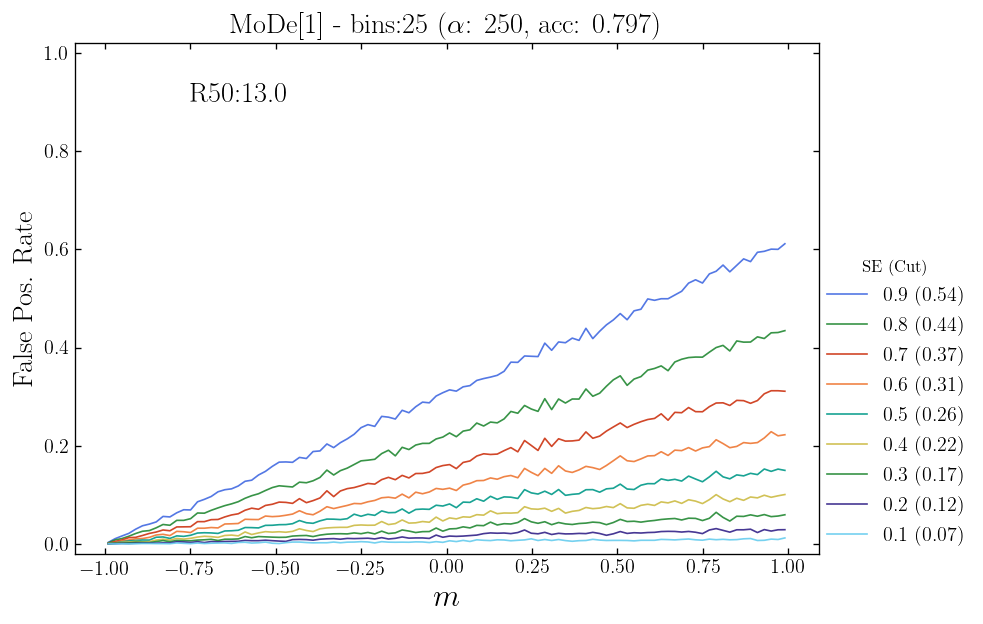

Entering Training...
Epoch:0001/0010  (4.2  s)
 Train: loss:0.2455, acc:80.4% || Val: loss: 0.1520, acc:78.2%, R50: 13.5006, 1/JSD: 0.2150
Epoch:0010/0010  (31.1 s)
 Train: loss:0.2200, acc:79.3% || Val: loss: 0.1353, acc:79.7%, R50: 13.1602, 1/JSD: 0.2167


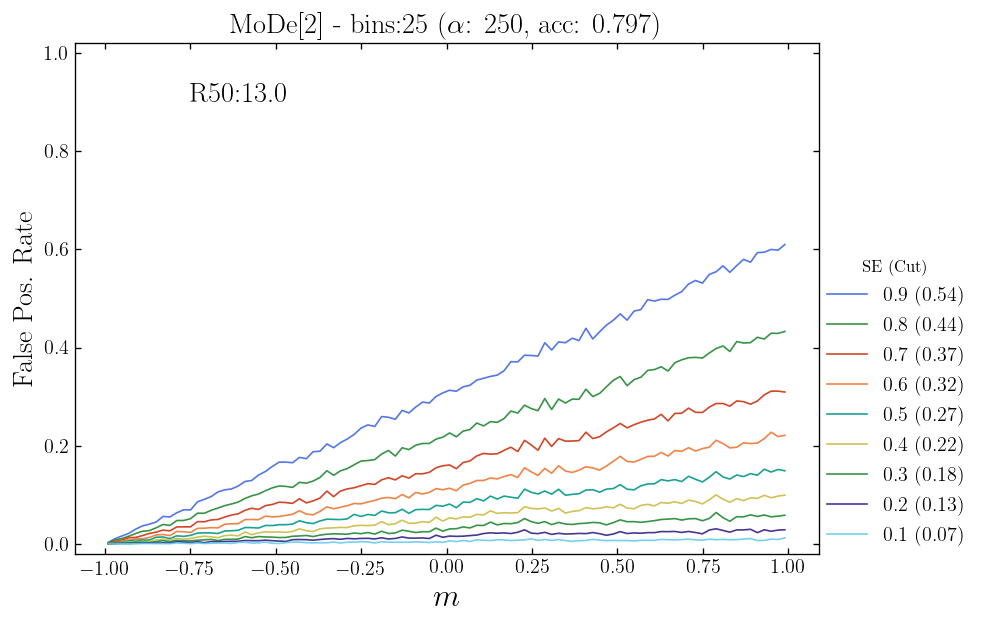

In [6]:
# ceneterd data
models = list()
bins = 25
alpha = 250
for order in [0,1,2]:
    torch.manual_seed(777)
    model = Model(input_size=traindataset.samples.shape[1]).to(device)
    MoDe = MoDeLoss(bins=bins,order=order,dynamicbins=True,background_label=1,
                                   #max_slope=slope,eps=1e-5, monotonic=True,
                                  background_only=True,normalize=False)
    loss = lambda pred,target,x_biased,weights: alpha * MoDe(pred,target,x_biased,) + torch.mean(weights*(target-pred)**2)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    model.fit(**params,traindataset=traindataset, valdataset=valdataset,
              optimizer=optimizer,loss=loss)
    models.append(model)
    with torch.no_grad():
        title = r"MoDe[{:d}] - bins:{:d} ($\alpha$: {:d}, acc: {:.3})"
        model.to("cpu")
        model.train(False)
        make_plot(model,Y=testTensor,
                   title=title.format(order,bins,alpha, model.metrics[1].accs[-1]),
                   bins=100)

Entering Training...
Epoch:0001/0010  (3.4  s)
 Train: loss:0.1373, acc:79.7% || Val: loss: 0.1646, acc:76.2%, R50: 12.8119, 1/JSD: 0.2177
Epoch:0010/0010  (23.1 s)
 Train: loss:0.1365, acc:79.3% || Val: loss: 0.1349, acc:79.8%, R50: 12.8119, 1/JSD: 0.2177


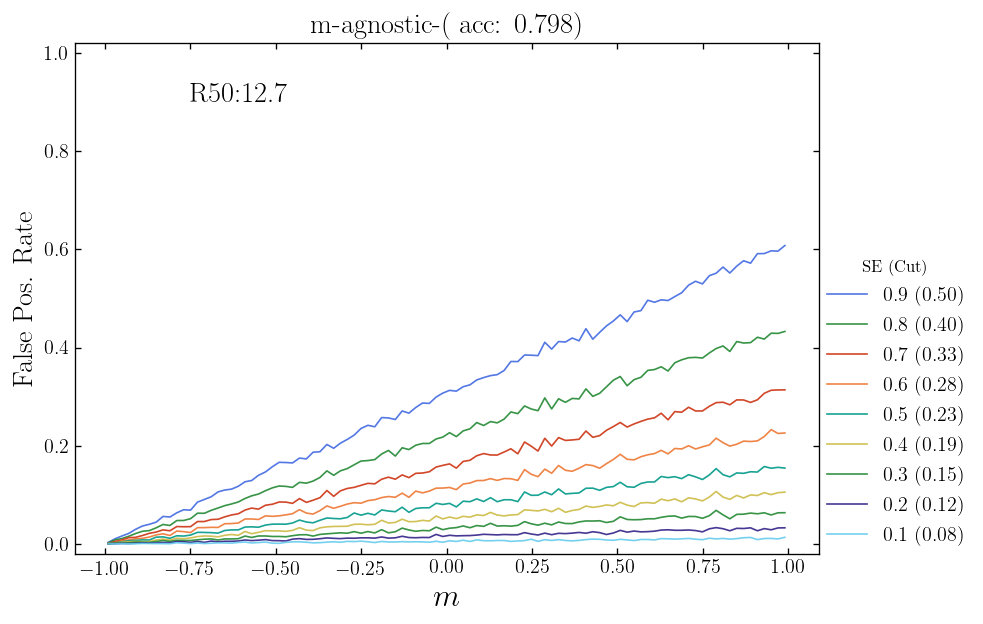

In [7]:
# ceneterd data
torch.manual_seed(777)
model = Model(input_size=traindataset2.samples.shape[1]).to(device)
loss = lambda pred,target,x_biased,weights: torch.mean(weights*(target-pred)**2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.fit(**params,traindataset=traindataset2, valdataset=valdataset2,
          optimizer=optimizer,loss=loss)
models.append(model)
with torch.no_grad():
    title = r"m-agnostic-( acc: {:.3})"
    model.to("cpu")
    model.train(False)
    make_plot(model,Y=testTensor2,
               title=title.format(model.metrics[1].accs[-1]),
               bins=100)

Entering Training...
Epoch:0001/0010  (3.2  s)
 Train: loss:0.1204, acc:82.6% || Val: loss: 0.1707, acc:80.8%, R50: 20.6166, 1/JSD: 0.0502
Epoch:0010/0010  (23.0 s)
 Train: loss:0.1230, acc:82.1% || Val: loss: 0.1207, acc:82.2%, R50: 20.5614, 1/JSD: 0.0379


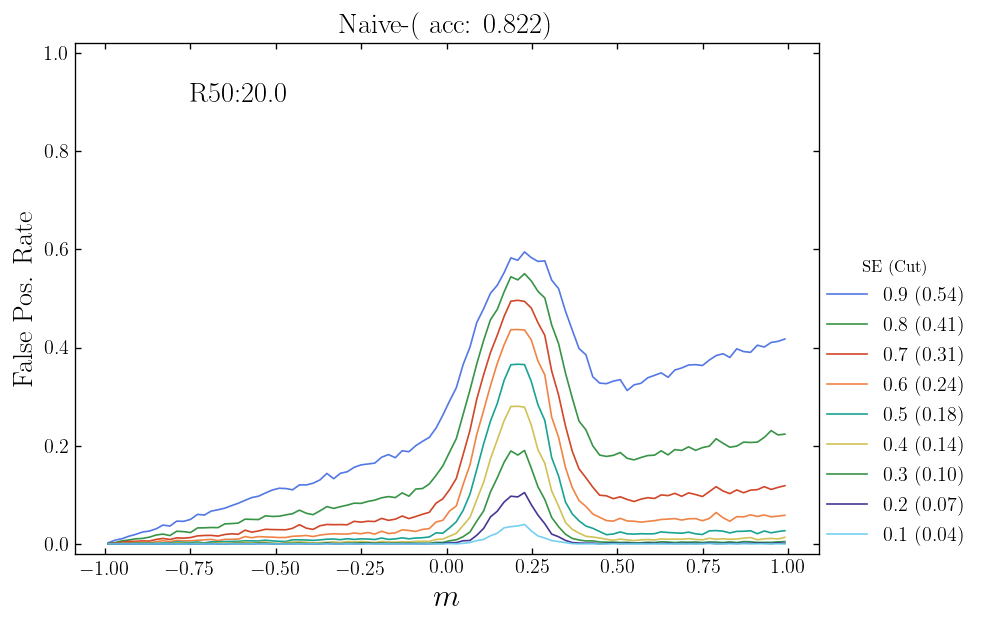

In [8]:
# ceneterd data
torch.manual_seed(777)
model = Model(input_size=traindataset.samples.shape[1]).to(device)
loss = lambda pred,target,x_biased,weights: torch.mean(weights*(target-pred)**2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.fit(**params,traindataset=traindataset, valdataset=valdataset,
          optimizer=optimizer,loss=loss)
models.append(model)
with torch.no_grad():
    title = r"Naive-( acc: {:.3})"
    model.to("cpu")
    model.train(False)
    make_plot(model,Y=testTensor,
               title=title.format(model.metrics[1].accs[-1]),
               bins=100)